In [62]:
# Based on https://www.programmersought.com/article/90154933316/#google_vignette

import os
import time
from datetime import datetime

import gym
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorlayer as tl
from gym.envs.toy_text.frozen_lake import generate_random_map

tl.logging.set_verbosity(tl.logging.DEBUG)
np.set_printoptions(suppress=True)

## 1. Normal DQN agent
This agent is not aware of the position of the chest

In [63]:
class DQNAgent():
    def __init__(self,
                  env=None,
                  discount_factor=0.7,
                  max_eps=1,
                  min_eps=0.1,
                  num_episodes=1_000_000,
                  eps_decay=0.9999975,
                  learning_rate=0.1
                  ):
        self.discount_factor = discount_factor
        self.max_eps = max_eps
        self.min_eps = min_eps
        self.num_episodes = num_episodes
        self.rList = [] # rewards
        self.alg_name = 'DQN'
        self.goal_reached_n = 0  # count the number of times the goal is reached
        self.eps = self.max_eps
        self.eps_decay = eps_decay
        self.q_table = np.zeros((100, 4))  # q table to better understand the learning process
        self.env = env
        self.learning_rate = learning_rate

        self.qnetwork = self.get_model([None, 100])
        self.qnetwork.train()  # set the network in trainable mode

        self.train_weights = self.qnetwork.trainable_weights
        self.optimizer = tf.optimizers.SGD(learning_rate=learning_rate)

    def to_one_hot(self, i, n_classes=None):  # one hot encode the state i
        a = np.zeros(n_classes, 'uint8')
        a[i] = 1
        return a

    def get_model(self, inputs_shape):
        # Q network definition
        # one-hot encoded state as input, 4 outputs as Q values for 4 actions
        input_layer = tl.layers.Input(inputs_shape, name='observation')
        output_layer = tl.layers.Dense(4, act=None, W_init=tf.random_uniform_initializer(0, 0.01), b_init=None, name='q_a_s')(input_layer)
        return tl.models.Model(inputs=input_layer, outputs=output_layer)

    def save_ckpt(self, model):  # save trained weights
        path = os.path.join('model', '_'.join([self.alg_name, str(self.learning_rate), str(self.discount_factor), datetime.now().strftime("%Y%m%d_%H%M%S")]))
        if not os.path.exists(path):
            os.makedirs(path)
        tl.files.save_weights_to_hdf5(os.path.join(path, 'dqn_model.hdf5'), model)

        # Save the environment description as well
        with open(os.path.join(path, 'env_desc.txt'), 'w') as f:
            f.write(str(self.env.desc))

    def train(self):
        flattened_map = self.env.desc.flatten()
        all_episode_reward = []
        for i in range(self.num_episodes):
            visited = set()
            s = self.env.reset()[0] # Reset environment and get first new observation
            rAll = 0
            while True:
                # Choose an action by greedily (with e chance of random action) from the Q-network
                allQ = self.qnetwork(np.asarray([self.to_one_hot(s, 100)], dtype=np.float32)).numpy()
                self.q_table[s] = allQ
                a = np.argmax(allQ, 1)

                if np.random.rand(1) < self.eps:  # explore if random number < epsilon
                    a[0] = self.env.action_space.sample() # choose random action

                next_state, r, d, _, _ = self.env.step(a[0])  #  perform the action and get the next state

                if next_state in visited:
                    r = -10
                elif next_state == s and not d:
                    r = -10
                elif flattened_map[next_state] == b'H':
                    r = -50
                elif flattened_map[next_state] == b'G':
                    r = 1000
                    self.goal_reached_n += 1
                elif flattened_map[next_state] == b'F':
                    r = -1
                
                # Obtain the Q values by feeding the new state through the network
                q1 = self.qnetwork(np.asarray([self.to_one_hot(next_state, 100)], dtype=np.float32)).numpy()

                # Greedily obtain maxQ and set target value for chosen action.
                max_q1 = np.max(q1) 
                targetQ = allQ
                targetQ[0, a[0]] = r + self.discount_factor * max_q1  # estimate q value
   
                with tf.GradientTape() as tape:
                    _qvalues = self.qnetwork(np.asarray([self.to_one_hot(s, 100)], dtype=np.float32))
                    _loss = tl.cost.mean_squared_error(targetQ, _qvalues, is_mean=False)
                grad = tape.gradient(_loss, self.train_weights)
                self.optimizer.apply_gradients(zip(grad, self.train_weights))

                rAll += r
                s = next_state
            
                if s not in visited:
                    visited.add(s)

                # Decrease epsilon after each episode
                if d == True:
                    if self.eps > self.min_eps:
                        self.eps *= self.eps_decay
                    break

            if i % 10000 == 0:
                print('Training  | Episode: {}/{}  | Episode Reward: {:.4f} | Epsilon: {:.4f} | Goal reached: {}' \
                        .format(i, self.num_episodes, rAll, self.eps, self.goal_reached_n))
            if i % 100000 == 0 :
                print(self.q_table)

            # for smooth reward plotting
            if i == 0:
                all_episode_reward.append(rAll)
            else:
                all_episode_reward.append(all_episode_reward[-1] * 0.9 + rAll * 0.1)

        self.save_ckpt(self.qnetwork)  # save model
        print(self.q_table)
        plt.plot(all_episode_reward)
        plt.title('Training Reward of the DQN Agent Over the Episodes')
        plt.xlabel('Episode')
        plt.ylabel('Reward')

        if not os.path.exists('image'):
            os.makedirs('image')
        plt.savefig(os.path.join('image', '_'.join([self.alg_name, str(self.learning_rate), str(self.discount_factor), datetime.now().strftime("%Y%m%d_%H%M%S")]) + '.png'))

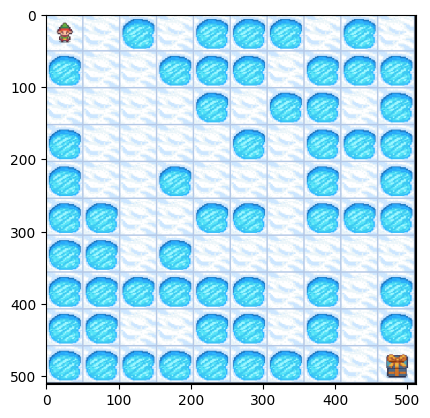

[TL] Input  observation: [None, 100]
[TL] Dense  q_a_s: 4 No Activation
___NORMAL___
[[b'S' b'F' b'H' b'F' b'H' b'H' b'H' b'F' b'H' b'F']
 [b'H' b'F' b'F' b'H' b'H' b'H' b'F' b'H' b'H' b'H']
 [b'F' b'F' b'F' b'F' b'H' b'F' b'H' b'H' b'F' b'H']
 [b'H' b'F' b'F' b'F' b'F' b'H' b'F' b'H' b'H' b'H']
 [b'H' b'F' b'F' b'H' b'F' b'F' b'F' b'H' b'F' b'H']
 [b'H' b'H' b'F' b'F' b'H' b'H' b'F' b'H' b'H' b'H']
 [b'H' b'H' b'F' b'H' b'F' b'F' b'F' b'F' b'F' b'F']
 [b'H' b'H' b'H' b'H' b'H' b'H' b'F' b'H' b'F' b'H']
 [b'H' b'H' b'F' b'F' b'H' b'H' b'F' b'H' b'F' b'H']
 [b'H' b'H' b'H' b'H' b'H' b'H' b'H' b'H' b'F' b'G']]
Training  | Episode: 0/1000000  | Episode Reward: -60.0000 | Epsilon: 1.0000 | Goal reached: 0
[[ 0.00976776  0.00341521  0.00818293 -1.99569225]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.     

KeyboardInterrupt: 

In [66]:
random_map = generate_random_map(size=10, p=0.3)    

env = gym.make("FrozenLake-v1", desc=random_map, render_mode="rgb_array")
env.reset()
plt.imshow(env.render())
plt.show()

agent = DQNAgent(env=env)
print("___NORMAL___")

print(env.desc)

agent.train()

## 2. DQN Agent using distance to goal
This agent knows about the goal position. 
It calculates the distance to the goal state and modifies the reward based on it.

In [67]:
class DQNAgentDistance():
    def __init__(self,
                  env=None,
                  discount_factor=0.7,
                  max_eps=1,
                  min_eps=0.1,
                  num_episodes=1_000_000,
                  eps_decay=0.9999975,
                  learning_rate=0.1
                  ):
        self.discount_factor = discount_factor
        self.max_eps = max_eps
        self.min_eps = min_eps
        self.num_episodes = num_episodes
        self.rList = [] #Record reward
        self.alg_name = 'DQN'
        self.goal_reached_n = 0  # count the number of times the goal is reached
        self.eps = self.max_eps
        self.eps_decay = eps_decay
        self.q_table = np.zeros((100, 4))

        # New attributes for the distance agent
        self.goal_position = np.array(np.where(env.desc == b'G')).flatten()
        self.position = np.array(np.where(env.desc == b'S')).flatten()
        self.max_distance = np.abs(self.position - self.goal_position).sum()

        self.env = env
        self.learning_rate = learning_rate

        self.qnetwork = self.get_model([None, 100])
        self.qnetwork.train()

        self.train_weights = self.qnetwork.trainable_weights
        self.optimizer = tf.optimizers.SGD(learning_rate=learning_rate)
  
    def to_one_hot(self, i, n_classes=None):  # one hot encode the state i
        a = np.zeros(n_classes, 'uint8')
        a[i] = 1
        return a

    def get_model(self, inputs_shape):
        # Q network definition
        # one-hot encoded state as input, 4 outputs as Q values for 4 actions
        input_layer = tl.layers.Input(inputs_shape, name='observation')
        output_layer = tl.layers.Dense(4, act=None, W_init=tf.random_uniform_initializer(0, 0.01), b_init=None, name='q_a_s')(input_layer)
        return tl.models.Model(inputs=input_layer, outputs=output_layer)

    def save_ckpt(self, model):  # save trained weights
        path = os.path.join('model', '_'.join(['distance', self.alg_name, str(self.learning_rate), str(self.discount_factor), datetime.now().strftime("%Y%m%d_%H%M%S")]))
        if not os.path.exists(path):
            os.makedirs(path)
        tl.files.save_weights_to_hdf5(os.path.join(path, 'dqn_model.hdf5'), model)

        with open(os.path.join(path, 'env_desc.txt'), 'w') as f:
            f.write(str(self.env.desc))

    def train(self):
        flattened_map = self.env.desc.flatten()
        all_episode_reward = []
        for i in range(self.num_episodes):
            visited = set()
            s = self.env.reset()[0] 
            rAll = 0
            while True:
                allQ = self.qnetwork(np.asarray([self.to_one_hot(s, 100)], dtype=np.float32)).numpy()
                self.q_table[s] = allQ
                a = np.argmax(allQ, 1)

                if np.random.rand(1) < self.eps:
                    a[0] = self.env.action_space.sample()

                next_state, r, d, _, _ = self.env.step(a[0])

                self.position = np.array([next_state // 10, next_state % 10])
                
                # Calculate the distance to the goal and use it to adjust the reward
                manhattan_distance = np.abs(self.position - self.goal_position).sum()
                dist_reward = manhattan_distance / self.max_distance

                if next_state in visited:
                    r = -10
                elif next_state == s and not d:
                    r = -10
                elif flattened_map[next_state] == b'H':
                    r = -50
                elif flattened_map[next_state] == b'G':
                    r = 1000
                    self.goal_reached_n += 1
                elif flattened_map[next_state] == b'F':
                    r = -1

                if r < 0:
                    r *= dist_reward  # Adjust the reward based on the distance to the goal
                
                # Obtain the Q values by feeding the new state through the network
                q1 = self.qnetwork(np.asarray([self.to_one_hot(next_state, 100)], dtype=np.float32)).numpy()

                # Greedily obtain maxQ and set target value for chosen action.
                max_q1 = np.max(q1) 
                targetQ = allQ
                targetQ[0, a[0]] = r + self.discount_factor * max_q1  # estimate q value
   
                with tf.GradientTape() as tape:
                    _qvalues = self.qnetwork(np.asarray([self.to_one_hot(s, 100)], dtype=np.float32))
                    _loss = tl.cost.mean_squared_error(targetQ, _qvalues, is_mean=False)
                grad = tape.gradient(_loss, self.train_weights)
                self.optimizer.apply_gradients(zip(grad, self.train_weights))

                rAll += r
                s = next_state
            
                if s not in visited:
                    visited.add(s)

                # Decrease epsilon after each episode
                if d == True:
                    if self.eps > self.min_eps:
                        self.eps *= self.eps_decay
                    break

            if i % 10000 == 0:
                print('Training  | Episode: {}/{}  | Episode Reward: {:.4f} | Epsilon: {:.4f} | Goal reached: {}' \
                        .format(i, self.num_episodes, rAll, self.eps, self.goal_reached_n))
            if i % 100000 == 0 :
                print(self.q_table)

            # for smooth reward plotting
            if i == 0:
                all_episode_reward.append(rAll)
            else:
                all_episode_reward.append(all_episode_reward[-1] * 0.9 + rAll * 0.1)

        self.save_ckpt(self.qnetwork)  # save model
        print(self.q_table)
        plt.plot(all_episode_reward)
        plt.title('Training Reward of the DQN Agent Over the Episodes')
        plt.xlabel('Episode')
        plt.ylabel('Reward')
        if not os.path.exists('image'):
            os.makedirs('image')
        plt.savefig(os.path.join('image', '_'.join(['distance', self.alg_name, str(self.learning_rate), str(self.discount_factor), datetime.now().strftime("%Y%m%d_%H%M%S")]) + '.png'))


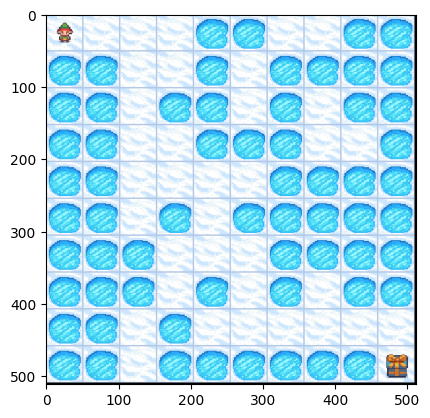

[TL] Input  observation: [None, 100]
[TL] Dense  q_a_s: 4 No Activation
___DISTANCE___
[[b'S' b'F' b'F' b'F' b'H' b'H' b'F' b'F' b'H' b'H']
 [b'H' b'H' b'F' b'F' b'H' b'F' b'H' b'H' b'H' b'H']
 [b'H' b'H' b'F' b'H' b'H' b'F' b'H' b'F' b'H' b'H']
 [b'H' b'H' b'F' b'F' b'H' b'H' b'H' b'F' b'F' b'H']
 [b'H' b'H' b'F' b'F' b'F' b'F' b'H' b'H' b'H' b'H']
 [b'H' b'H' b'F' b'H' b'F' b'H' b'H' b'H' b'H' b'H']
 [b'H' b'H' b'H' b'F' b'F' b'F' b'H' b'H' b'H' b'H']
 [b'H' b'H' b'H' b'F' b'H' b'F' b'H' b'F' b'H' b'H']
 [b'H' b'H' b'F' b'H' b'F' b'F' b'F' b'F' b'F' b'F']
 [b'H' b'H' b'F' b'H' b'H' b'H' b'H' b'H' b'H' b'G']]
Training  | Episode: 0/1000000  | Episode Reward: -67.2222 | Epsilon: 1.0000 | Goal reached: 0
[[ 0.00624741 -1.99609196  0.00876349 -1.99500024]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.   

c:\Users\kuba\OneDrive\Pulpit\studia\year 5\applied ai\assessment1\CS5079_AppliedAI\.venv\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


KeyboardInterrupt: 

In [68]:
random_map = generate_random_map(size=10, p=0.3)  

env = gym.make("FrozenLake-v1", desc=random_map, render_mode="rgb_array")
env.reset()
plt.imshow(env.render())
plt.show()

distance_agent = DQNAgentDistance(env=env)
print('___DISTANCE___')

print(env.desc)

distance_agent.train()

## 3. DQN agent encouraging moves down and right (direction agent)
This agent is also aware of the goal position, but uses it differently.

On top of modifying the reward based on the distance, it also initialises the weights of the neural network with higher values for actions to go down and right.

In [69]:
class DQNAgentDirection():
    def __init__(self,
                  env=None,
                  discount_factor=0.7,
                  max_eps=1,
                  min_eps=0.1,
                  num_episodes=1_000_000,
                  eps_decay=0.9999975,
                  learning_rate=0.1
                  ):
        self.discount_factor = discount_factor
        self.max_eps = max_eps
        self.min_eps = min_eps
        self.num_episodes = num_episodes
        self.rList = [] #Record reward
        self.alg_name = 'DQN'
        self.goal_reached_n = 0  # count the number of times the goal is reached
        self.eps = self.max_eps
        self.eps_decay = eps_decay
        self.q_table = np.zeros((100, 4))
        self.goal_position = np.array(np.where(env.desc == b'G')).flatten()
        self.position = np.array(np.where(env.desc == b'S')).flatten()
        self.max_distance = np.abs(self.position - self.goal_position).sum()

        self.env = env
        self.learning_rate = learning_rate

        self.qnetwork = self.get_model([None, 100])
        self.qnetwork.train()

        self.train_weights = self.qnetwork.trainable_weights
        self.optimizer = tf.optimizers.SGD(learning_rate=learning_rate)
  
    def to_one_hot(self, i, n_classes=None):  # one hot encode the state i
        a = np.zeros(n_classes, 'uint8')
        a[i] = 1
        return a

    def get_model(self, inputs_shape):
        # Q network definition
        # one-hot encoded state as input, 4 outputs as Q values for 4 actions

        # Initialise the weights to be higher for actions to go down and right
        init_weights = np.hstack((np.random.uniform(0, 0.01, (100, 1)), 
                        np.random.uniform(0.5, 0.51, (100, 1)), # down
                        np.random.uniform(0.5, 0.51, (100, 1)), # right
                        np.random.uniform(0, 0.01, (100, 1)))).astype('float32')
        
        ni = tl.layers.Input(inputs_shape, name='observation')
        nn = tl.layers.Dense(4, act=None, W_init=tf.constant_initializer(init_weights), b_init=None, name='q_a_s')(ni)
        return tl.models.Model(inputs=ni, outputs=nn)
    
    def save_ckpt(self, model):  # save trained weights
        path = os.path.join('model', '_'.join(['direction', self.alg_name, str(self.learning_rate), str(self.discount_factor), datetime.now().strftime("%Y%m%d_%H%M%S")]))
        if not os.path.exists(path):
            os.makedirs(path)
        tl.files.save_weights_to_hdf5(os.path.join(path, 'dqn_model.hdf5'), model)

        with open(os.path.join(path, 'env_desc.txt'), 'w') as f:
            f.write(str(self.env.desc))

    def train(self):
        flattened_map = self.env.desc.flatten()
        all_episode_reward = []
        for i in range(self.num_episodes):
            visited = set()
            s = self.env.reset()[0] 
            rAll = 0
            while True:
                allQ = self.qnetwork(np.asarray([self.to_one_hot(s, 100)], dtype=np.float32)).numpy()
                self.q_table[s] = allQ
                a = np.argmax(allQ, 1)

                if np.random.rand(1) < self.eps:
                    a[0] = self.env.action_space.sample()

                next_state, r, d, _, _ = self.env.step(a[0])

                self.position = np.array([next_state // 10, next_state % 10])
                
                # Calculate the distance to the goal and use it to adjust the reward
                manhattan_distance = np.abs(self.position - self.goal_position).sum()
                dist_reward = manhattan_distance / self.max_distance

                if next_state in visited:
                    r = -10
                elif next_state == s and not d:
                    r = -10
                elif flattened_map[next_state] == b'H':
                    r = -50
                elif flattened_map[next_state] == b'G':
                    r = 1000
                    self.goal_reached_n += 1
                elif flattened_map[next_state] == b'F':
                    r = -1

                if r < 0:
                    r *= dist_reward  # Adjust the reward based on the distance to the goal
                
                # Obtain the Q values by feeding the new state through the network
                q1 = self.qnetwork(np.asarray([self.to_one_hot(next_state, 100)], dtype=np.float32)).numpy()

                # Greedily obtain maxQ and set target value for chosen action.
                max_q1 = np.max(q1) 
                targetQ = allQ
                targetQ[0, a[0]] = r + self.discount_factor * max_q1  # estimate q value
   
                with tf.GradientTape() as tape:
                    _qvalues = self.qnetwork(np.asarray([self.to_one_hot(s, 100)], dtype=np.float32))
                    _loss = tl.cost.mean_squared_error(targetQ, _qvalues, is_mean=False)
                grad = tape.gradient(_loss, self.train_weights)
                self.optimizer.apply_gradients(zip(grad, self.train_weights))

                rAll += r
                s = next_state
            
                if s not in visited:
                    visited.add(s)

                # Decrease epsilon after each episode
                if d == True:
                    if self.eps > self.min_eps:
                        self.eps *= self.eps_decay
                    break

            if i % 10000 == 0:
                print('Training  | Episode: {}/{}  | Episode Reward: {:.4f} | Epsilon: {:.4f} | Goal reached: {}' \
                        .format(i, self.num_episodes, rAll, self.eps, self.goal_reached_n))
            if i % 100000 == 0 :
                print(self.q_table)

            # for smooth reward plotting
            if i == 0:
                all_episode_reward.append(rAll)
            else:
                all_episode_reward.append(all_episode_reward[-1] * 0.9 + rAll * 0.1)

        self.save_ckpt(self.qnetwork)  # save model
        print(self.q_table)
        plt.plot(all_episode_reward)
        plt.title('Training Reward of the DQN Agent Over the Episodes')
        plt.xlabel('Episode')
        plt.ylabel('Reward')
        if not os.path.exists('image'):
            os.makedirs('image')
        plt.savefig(os.path.join('image', '_'.join(['direction', self.alg_name, str(self.learning_rate), str(self.discount_factor), datetime.now().strftime("%Y%m%d_%H%M%S")]) + '.png'))


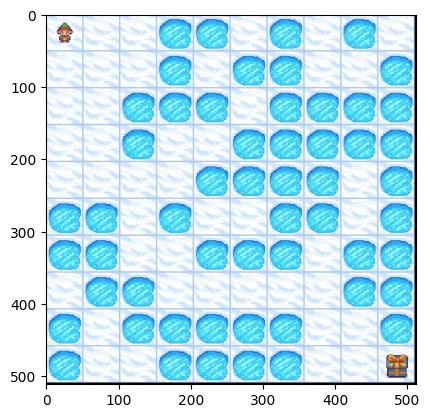

[TL] Input  observation: [None, 100]
[TL] Dense  q_a_s: 4 No Activation
___DIRECTION___
[[b'S' b'F' b'F' b'H' b'H' b'F' b'H' b'F' b'H' b'F']
 [b'F' b'F' b'F' b'H' b'F' b'H' b'H' b'F' b'F' b'H']
 [b'F' b'F' b'H' b'H' b'H' b'F' b'H' b'H' b'H' b'H']
 [b'F' b'F' b'H' b'F' b'F' b'H' b'H' b'H' b'H' b'H']
 [b'F' b'F' b'F' b'F' b'H' b'H' b'H' b'H' b'F' b'H']
 [b'H' b'H' b'F' b'H' b'F' b'F' b'H' b'H' b'F' b'H']
 [b'H' b'H' b'F' b'F' b'H' b'H' b'H' b'F' b'H' b'H']
 [b'F' b'H' b'H' b'F' b'F' b'F' b'F' b'F' b'H' b'H']
 [b'H' b'F' b'H' b'H' b'H' b'H' b'H' b'F' b'F' b'H']
 [b'H' b'F' b'F' b'H' b'H' b'H' b'H' b'F' b'F' b'G']]
[<tf.Variable 'q_a_s/weights:0' shape=(100, 4) dtype=float32, numpy=
array([[0.00219071, 0.5017295 , 0.503118  , 0.00380612],
       [0.00670911, 0.500737  , 0.5057754 , 0.00047044],
       [0.00354899, 0.5001338 , 0.5071497 , 0.00599509],
       [0.00673676, 0.5035173 , 0.5021892 , 0.00926112],
       [0.00884259, 0.5070988 , 0.50334126, 0.0092022 ],
       [0.00133892, 0.50985

c:\Users\kuba\OneDrive\Pulpit\studia\year 5\applied ai\assessment1\CS5079_AppliedAI\.venv\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):



[[ 0.00219071  0.50172949  0.50311798  0.00380612]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.00436896  0.50034249  0.50991046  0.00800841]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0. 

KeyboardInterrupt: 

In [71]:
random_map = generate_random_map(size=10, p=0.3)  

env = gym.make("FrozenLake-v1", desc=random_map, render_mode="rgb_array")
env.reset()
plt.imshow(env.render())
plt.show()

direction_agent = DQNAgentDirection(env=env)
print("___DIRECTION___")

print(env.desc)
print(direction_agent.qnetwork.trainable_weights)

direction_agent.train()

# Testing phase

Runs a saved Direction DQN Agent model on the environment it was trained on to record the video

In [53]:
from datetime import datetime
import os
import time

import gym
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorlayer as tl
from tensorflow.keras.layers import Dense, InputLayer
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import SGD
from gym.envs.toy_text.frozen_lake import generate_random_map
from IPython.display import clear_output
import argparse
class Test_Direction_DQNAgent():
    def __init__(self,
                  env=None,
                  max_eps=1,
                  min_eps=0.1,
                  ):
        self.max_eps = max_eps
        self.min_eps = min_eps
        self.rList = [] #Record reward
        self.alg_name = 'DQN'
        self.goal_reached_n = 0  # count the number of times the goal is reached
        self.eps = self.max_eps
        self.q_table = np.zeros((100, 4))
        self.recorder = env
        self.env = env.env
        self.goal_position = np.array(np.where(self.env.desc == b'G')).flatten()
        self.position = np.array(np.where(self.env.desc == b'S')).flatten()
        self.max_distance = np.abs(self.position - self.goal_position).sum()
        

        self.qnetwork = self.get_model([100])




    ##################### DQN ##########################
    def to_one_hot(self, i, n_classes=None):
        a = np.zeros(n_classes, 'uint8')
        a[i] = 1
        return a


    ## Define Q-network q(a,s) that ouput the rewards of 4 actions by given state, i.e. Action-Value Function.
    # encoding for state: 10x10 grid can be represented by one-hot vector with 100 integers.
    def get_model(self,input_shape):
        #init_weights = np.hstack((np.random.uniform(0, 0.01, (100, 1)), 
        #                np.random.uniform(0.5, 0.51, (100, 1)), 
        #                np.random.uniform(0.5, 0.51, (100, 1)), 
        #                np.random.uniform(0, 0.01, (100, 1)))).astype('float32')
        
        #ni = tl.layers.Input(inputs_shape, name='observation')
        #nn = tl.layers.Dense(4, act=None, W_init=tf.constant_initializer(init_weights), b_init=None, name='q_a_s')(ni)
        #return tl.models.Model(inputs=ni, outputs=nn)
        model = Sequential([
            InputLayer(input_shape),
            Dense(4, activation='linear',use_bias=False)])
        model.compile(optimizer=SGD(learning_rate=0.1), loss=MeanSquaredError())
        return model

    
    def save_ckpt(self, model):  # save trained weights
        path = os.path.join('model', '_'.join(['direction', self.alg_name, str(self.learning_rate), str(self.discount_factor), datetime.now().strftime("%Y%m%d_%H%M%S")]))
        if not os.path.exists(path):
            os.makedirs(path)
        tl.files.save_weights_to_hdf5(os.path.join(path, 'dqn_model.hdf5'), model)

        with open(os.path.join(path, 'env_desc.txt'), 'w') as f:
            f.write(str(self.env.desc))


    def load_ckpt(self, model, path):  # load trained weights
        
        model.load_weights(path)


    def test(self):
        done = False
        episodes = 0
        while not done:
            ## Reset environment and get first new observation
            s = self.env.reset()[0]  # observation is state
            d = False
            episodes += 1
            print(episodes)
            while d is False:
                ## Choose an action by greedily (with e chance of random action) from the Q-network
                state_basic=s
                state_arr=np.zeros(100)
                state_arr[s] = 1
                s = np.reshape(state_arr, [1, 100])
                model_output = self.qnetwork.predict(s,verbose=0)
                allQ = model_output
                self.q_table[state_basic] = allQ
                a = np.argmax(allQ)
                
                ## Get new state and reward from self.ironment
                next_state, r, d, _, _ = self.env.step(a)
                
                #clear_output(wait=True)
                #plt.imshow(self.env.render())
                self.recorder.capture_frame()
                #display(plt.gcf())
                
                
                s = next_state

                if r == 1:
                    done = True
                



In [54]:
from gym.wrappers.monitoring.video_recorder import VideoRecorder

map = ['SFFFHHHHHF','HFFFHHFFHF','HHFFHHFHHH','HFFFHFHHHF','HHFHHHHHFH','FHFFHHFHHF','FFHFFFHHHH','HHHFFFFHHH','HHHFHFFFHH','HHHHHHFFFG']
env = gym.make("FrozenLake-v1", desc=map,render_mode="rgb_array",is_slippery=True)
env.reset()

video_record = "frozenlake.mp4"
video = VideoRecorder(env,video_record)
video.frames_per_sec = 4
video.capture_frame()


np.set_printoptions(suppress=True)
agent = Test_Direction_DQNAgent(env=video)
path = "./model/direction_DQN_0.1_0.8/dqn_model.hdf5"
agent.load_ckpt(agent.qnetwork,path)
agent.test()
video.close()
env.close()

1


c:\Users\Tom Utting\Documents\School Work\Fifth Year\CS5079 Applied AI\CS5079_AppliedAI\.venv\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
MoviePy - Building video frozenlake.mp4.
MoviePy - Writing video frozenlake.mp4



MoviePy - Done !
MoviePy - video ready frozenlake.mp4
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
MoviePy - Building video frozenlake.mp4.
MoviePy - Writing video frozenlake.mp4



MoviePy - Done !
MoviePy - video ready frozenlake.mp4
